# <font color='darkorange'> C01 - Recency Frequency Monetary ( RFM )

# 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import warnings
import inflection
import numpy             as np
import pandas            as pd

import seaborn           as sns
import matplotlib.pyplot as plt

from src                 import Starts
import pipeline_class

from sklearn.pipeline    import Pipeline
from sklearn.base        import BaseEstimator, TransformerMixin

/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/pyth

## 0.1. Helper Functions

In [3]:
starts = Starts()
starts.jupyter_settings()

## 0.2. Load Data

In [4]:
# Load Data
data_raw = pd.read_csv("data/raw/Ecommerce.csv", encoding='unicode_escape')

# Drop "Unnamed: 8" column
data_raw = data_raw.drop(columns = "Unnamed: 8")

| Column Name | Description                                            |
|-------------|--------------------------------------------------------|
| InvoiceNo   | Invoice number, a unique identifier for each transaction |
| StockCode   | Product code, a unique identifier for each product       |
| Description | Product description                                     |
| Quantity    | Quantity of products purchased in each transaction      |
| InvoiceDate | Date and time of each transaction                        |
| UnitPrice   | Unit price of each product                              |
| CustomerID  | Customer ID, a unique identifier for each customer       |
| Country     | Country of the customer                                 |


# 1.0. Data Description

In [5]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [6]:
# Class responsible for renaming columns. 
# It is inside utils directory
class RenameDataframeColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)
        
        return X
    
    def rename_columns(self, dataframe):
        # Copy DataFrame
        df = dataframe.copy()
        
        # Columns Names
        cols_old = list(df.columns)

        # Function to convert columns names to snake_case pattern
        snakecase = lambda x: inflection.underscore(x)

        # New columns names
        cols_new = list(map(snakecase, cols_old))

        # Apply new columns names to DataFrame
        df.columns = cols_new
        
        return df

In [7]:
# Create Pipeline to rename DataFrame
rename_pipe = Pipeline([
    ('rename', pipeline_class.RenameDataframeColumns())])

rename_pipe

Pipeline(steps=[('rename', RenameDataframeColumns())])

In [8]:

# Use Pipeline to rename DataFrame Columns
df1 = rename_pipe.fit_transform(df1)
df1.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2. Data Dimensions

In [9]:
starts.data_dimensions(df1)

Number of rows: 541909
Number of cols: 8


## 1.3. Data Checks ( Types and NA )

In [10]:
starts.type_na(df1)

,Type,number na,percent na
invoice_no,object,0,0.0 %
stock_code,object,0,0.0 %
description,object,1454,0.27 %
quantity,int64,0,0.0 %
invoice_date,object,0,0.0 %
unit_price,float64,0,0.0 %
customer_id,float64,135080,24.93 %
country,object,0,0.0 %


In [11]:
# Convert date for datetime
df1.invoice_date = pd.to_datetime( df1.invoice_date, format='%d-%b-%y')

To check if invoices have a problem in some rows, I check if, in all the invoices with error, none have a customer id.

In [12]:
invoice_without_customers = df1[df1.customer_id.isna()].invoice_no
df1[df1.invoice_no.isin(invoice_without_customers)].customer_id.sum()

0.0

As, all the invoices with errors, don't have a customer id, I decide to drop that's invoices.

In [13]:
# drop na
df1 = df1.dropna( subset=['description', 'customer_id'] )

starts.type_na(df1)

,Type,number na,percent na
invoice_no,object,0,0.0 %
stock_code,object,0,0.0 %
description,object,0,0.0 %
quantity,int64,0,0.0 %
invoice_date,datetime64[ns],0,0.0 %
unit_price,float64,0,0.0 %
customer_id,float64,0,0.0 %
country,object,0,0.0 %


# 2.0. EDA

In [14]:
df2 = df1.copy()

In [15]:
starts.statistics_info(df2)

,Non-Null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
quantity,406829,161990.0,-80995.0,2.00,5.00,12.00,80995.0,12.061303,248.693370,0.182663,94317.563673
unit_price,406829,38970.0,0.0,1.25,1.95,3.75,38970.0,3.460471,69.315162,452.219019,246924.542988
customer_id,406829,5941.0,12346.0,13953.00,15152.00,16791.00,18287.0,15287.690570,1713.600303,0.029835,-1.179982


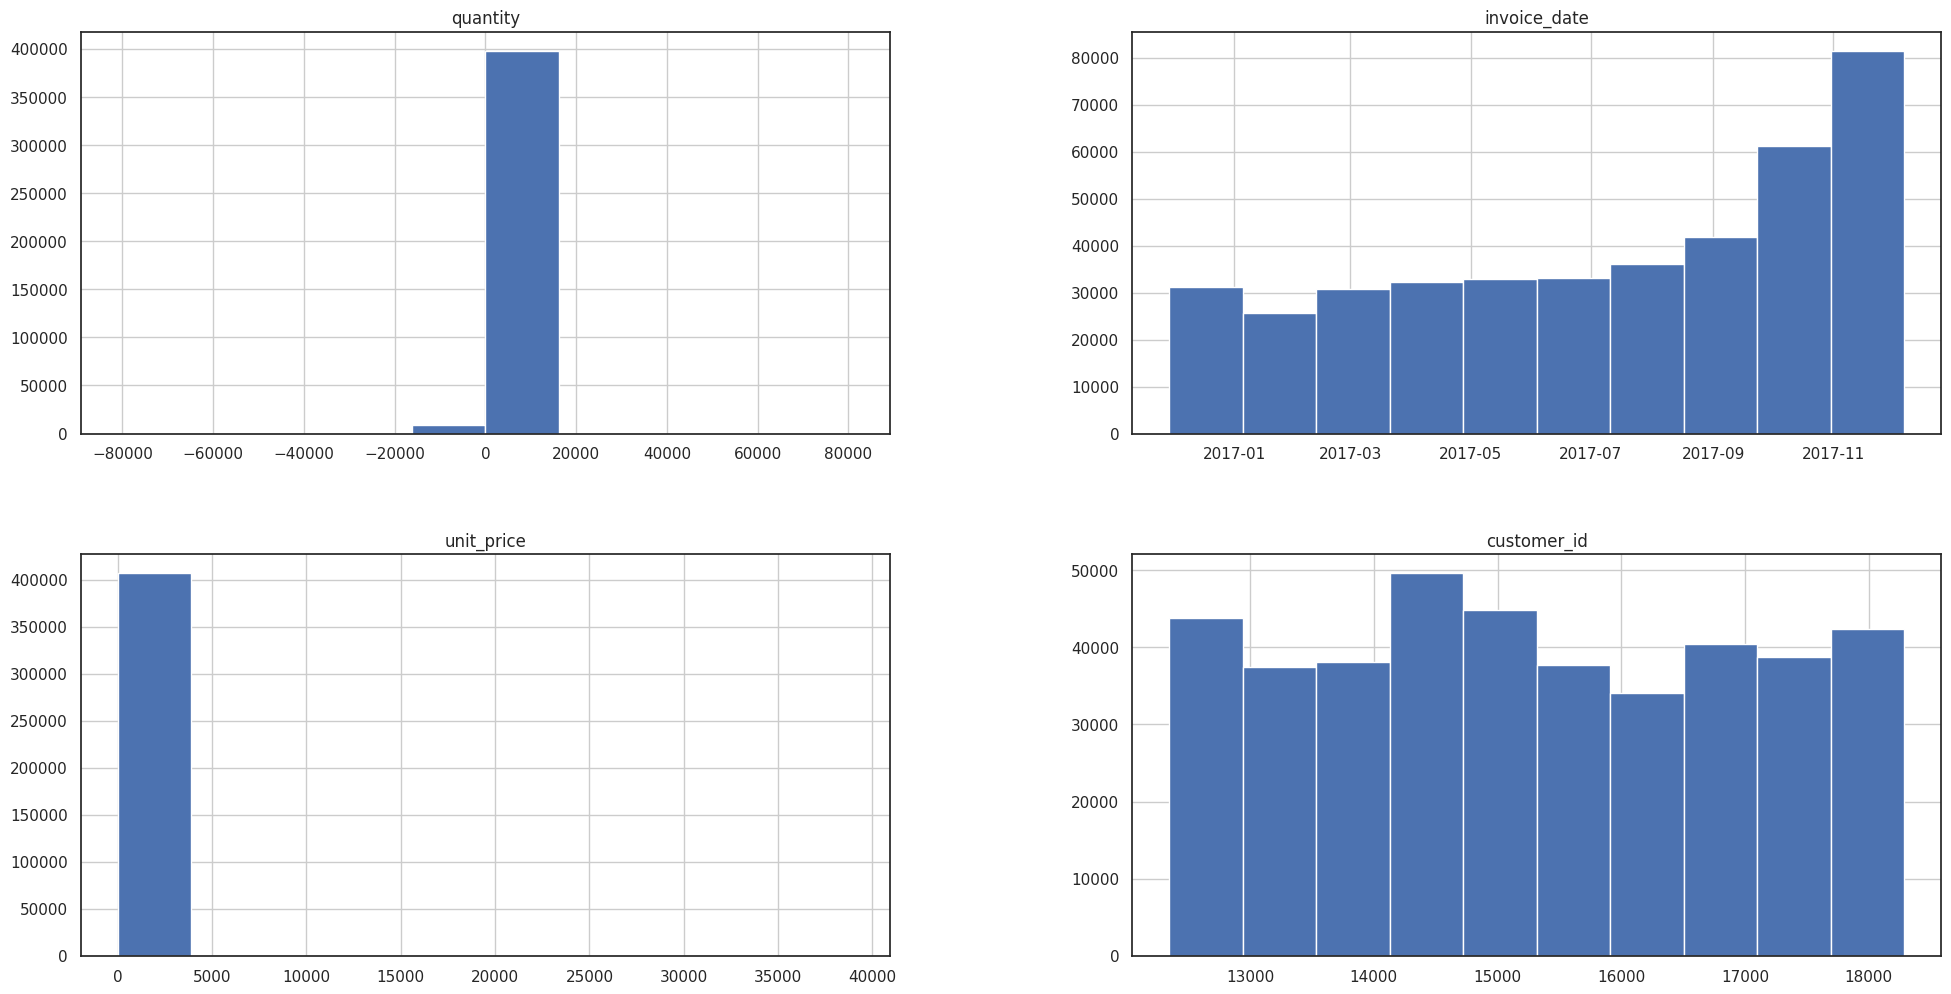

In [16]:
df2.hist();

## 2.1. Invoice_no

In [17]:
returned_invoices = df2.invoice_no.str.contains(pat='[a-zA-Z]', regex=True)
df2[returned_invoices].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom


Invoices with letters means it is a return transaction as indicated by the negative values ​​in the column quantity.

In [18]:
df2[df2.invoice_no.isin(df2[returned_invoices].invoice_no.str[1:])]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


After checking if there were any purchase and return transactions, I found out that all transactions were returns. This means that the invoices were modified with a letter and negative values to indicate the return of items. Since these transactions do not contribute to my model, I decided to drop them from the dataset.

## 2.2. quantity	

In [19]:
df2[ df2.quantity > df2.quantity.quantile(0.99999) ].sort_values("quantity", ascending=False)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2017-11-23,0.00,13256.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2017-10-25,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2017-05-25,0.72,13135.0,United Kingdom


In a brief check, I found that the products purchased in large quantities are small products, like papercraft. As that purchases made sense I maintain the dataset.

## 2.3. Unit_price

In [20]:
starts.statistics_info(df2)

,Non-Null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
quantity,406829,161990.0,-80995.0,2.00,5.00,12.00,80995.0,12.061303,248.693370,0.182663,94317.563673
unit_price,406829,38970.0,0.0,1.25,1.95,3.75,38970.0,3.460471,69.315162,452.219019,246924.542988
customer_id,406829,5941.0,12346.0,13953.00,15152.00,16791.00,18287.0,15287.690570,1713.600303,0.029835,-1.179982


In [21]:
df2[ df2.unit_price	> df2.unit_price.quantile(0.99995) ].sort_values("unit_price", ascending=False)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
222681,C556445,M,Manual,-1,2017-06-08,38970.00,15098.0,United Kingdom
173277,C551685,POST,POSTAGE,-1,2017-05-01,8142.75,16029.0,United Kingdom
173382,551697,POST,POSTAGE,1,2017-05-01,8142.75,16029.0,United Kingdom
173391,C551699,M,Manual,-1,2017-05-01,6930.00,16029.0,United Kingdom
268027,C560372,M,Manual,-1,2017-07-16,4287.63,17448.0,United Kingdom
422376,573080,M,Manual,1,2017-10-25,4161.06,12536.0,France
422375,C573079,M,Manual,-2,2017-10-25,4161.06,12536.0,France
422351,573077,M,Manual,1,2017-10-25,4161.06,12536.0,France
406406,571751,M,Manual,1,2017-10-17,3949.32,12744.0,Singapore
406404,C571750,M,Manual,-1,2017-10-17,3949.32,12744.0,Singapore


After checking the unit_price column, I found that the big values ​​are services provided by the company, that's explains the big numbers.

# 3.0. Data Filtering

In [22]:
df3 = df2.copy()

In [23]:
starts.data_dimensions(df2)

print( f'\nAfter dropping {df2[returned_invoices].shape[0]} rows of invoices with return transactions.\n')

df2 = df2[~(returned_invoices)]

starts.data_dimensions(df2)

Number of rows: 406829
Number of cols: 8

After dropping 8905 rows of invoices with return transactions.

Number of rows: 397924
Number of cols: 8


# 4.0. Feature Engineering

In [24]:
df4 = df3.copy()

In [25]:
# Gross Revenue ( quantity * unit_price )
df4['gross_revenue'] = df4.quantity * df4.unit_price
df4.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom,20.34


In [26]:
# Monetary
monetary = df4.groupby('customer_id')[['gross_revenue']].sum().reset_index()

# Recency
recency = df4.groupby('customer_id')[['invoice_date']].max().reset_index()
recency['recency_days'] = (df4.invoice_date.max() - recency.invoice_date).dt.days

# Frequency
frequency = df4.groupby('customer_id')[['invoice_no']].nunique().reset_index()

# Merge Data for RFM
customers_ref = monetary.merge( recency[['customer_id', 'recency_days']], on='customer_id', how='left')
customers_ref = customers_ref.merge(frequency, on='customer_id', how='left')

# Rename columns
customers_ref = customers_ref.rename(columns={'invoice_no': 'frequency',
                                              'gross_revenue': 'monetary',
                                              'recency_days': 'recency'})

In [27]:
customers_ref.head()

,customer_id,monetary,recency,frequency
0,12346.0,0.00,325,2
1,12347.0,4310.00,2,7
2,12348.0,1797.24,75,4
3,12349.0,1757.55,18,1
4,12350.0,334.40,310,1


# 5.0. Recency Frequency Monetary ( RFM )

RFM stands for Recency, Frequency, and Monetary. It is a method used to segment customers based on their buying behavior.

Recency refers to how recently a customer has made a purchase. Customers who have made a purchase more recently are considered more valuable than those who made a purchase a long time ago.

Frequency refers to how often a customer makes a purchase. Customers who make purchases more frequently are considered more valuable than those who make purchases less often.

Monetary refers to how much a customer spends on purchases. Customers who spend more are considered more valuable than those who spend less.

Using these three factors, RFM analysis can divide customers into groups based on their overall value to the business. This information can then be used to tailor marketing strategies to each group and improve overall customer retention and profitability.

In [28]:
def rfm_function(customer_info):

    # select the cols for RFM
    rfm_table = customer_info.copy()

    # define the intervals
    r_labels = range(5, 0, -1)
    fm_labels = range(1, 6)

    # binning
    rfm_table["R"] = pd.qcut(rfm_table["recency"], 5, labels = r_labels)
    rfm_table["F"] = pd.qcut(rfm_table["frequency"].rank(method = 'first'), 5, labels = fm_labels)
    rfm_table["M"] = pd.qcut(rfm_table["monetary"], 5, labels = fm_labels)

    # make cluster col
    rfm_table["RFM_segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)

    # make RFM score
    rfm_table["RFM_score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

    # make a map for name the cluster
    segt_map = {
        r'[1-2][1-2]': 'Hibernating',
        r'[1-2][3-4]': 'At-Risk',
        r'[1-2]5': 'Cannot lose them',
        r'3[1-2]': 'About To Sleep',
        r'33': 'Need Attention',
        r'[3-4][4-5]': 'Loyal Customers',
        r'41': 'Promising',
        r'51': 'New Customers',
        r'[4-5][2-3]': 'Potential Loyalists',
        r'5[4-5]': 'Champions'
    }

    # map cluster
    rfm_table['segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
    rfm_table['segment'] = rfm_table['segment'].replace(segt_map, regex=True)

    return rfm_table

In [29]:
def plot_rfm(rfm_table):

    ## Visualizing RFM Grid
    rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                       "Loyal Customers": [3, 5, 0.4, 0.8],
                       "Cannot lose them": [4, 5, 0, 0.4],
                       "At-Risk": [2, 4, 0, 0.4],
                       "Hibernating": [0, 2, 0, 0.4],
                       "About To Sleep": [0, 2, 0.4, 0.6],
                       "Promising": [0, 1, 0.6, 0.8],
                       "New Customers": [0, 1, 0.8, 1],
                       "Potential Loyalists": [1, 3, 0.6, 1],
                       "Need Attention": [2, 3, 0.4, 0.6]}

    fig, ax = plt.subplots(figsize = (19, 15))

    ax.set_xlim([0, 5])
    ax.set_ylim([0, 5])

    plt.rcParams["axes.facecolor"] = "white"
    palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
               "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

    for key, color in zip(rfm_coordinates.keys(), palette[:10]):

        coordinates = rfm_coordinates[key]
        ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]

        ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)

        users = rfm_table[rfm_table.segment == key].shape[0]
        users_percentage = (rfm_table[rfm_table.segment == key].shape[0] / rfm_table.shape[0]) * 100
        avg_monetary = rfm_table[rfm_table.segment == key]["monetary"].mean()

        user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
        monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))

        x = 5 * (xmin + xmax) / 2
        y = (ymin + ymax) / 2

        plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
        plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
        plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    

        ax.set_xlabel("Recency Score")
        ax.set_ylabel("Frequency Score")

    sns.despine(left = True, bottom = True)
    plt.show()

    return None

In [30]:
rfm_table = rfm_function(customers_ref)
rfm_table

,customer_id,monetary,recency,frequency,R,F,M,RFM_segment,RFM_score,segment
0,12346.0,0.00,325,2,1,2,1,121,4,Hibernating
1,12347.0,4310.00,2,7,5,4,5,545,14,Champions
2,12348.0,1797.24,75,4,2,3,4,234,9,At-Risk
3,12349.0,1757.55,18,1,4,1,4,414,9,Promising
4,12350.0,334.40,310,1,1,1,2,112,4,Hibernating
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,180.60,277,1,1,2,1,121,4,Hibernating
4368,18281.0,80.82,180,1,1,2,1,121,4,Hibernating
4369,18282.0,176.60,7,3,5,3,1,531,9,Potential Loyalists
4370,18283.0,2094.88,3,16,5,5,5,555,15,Champions


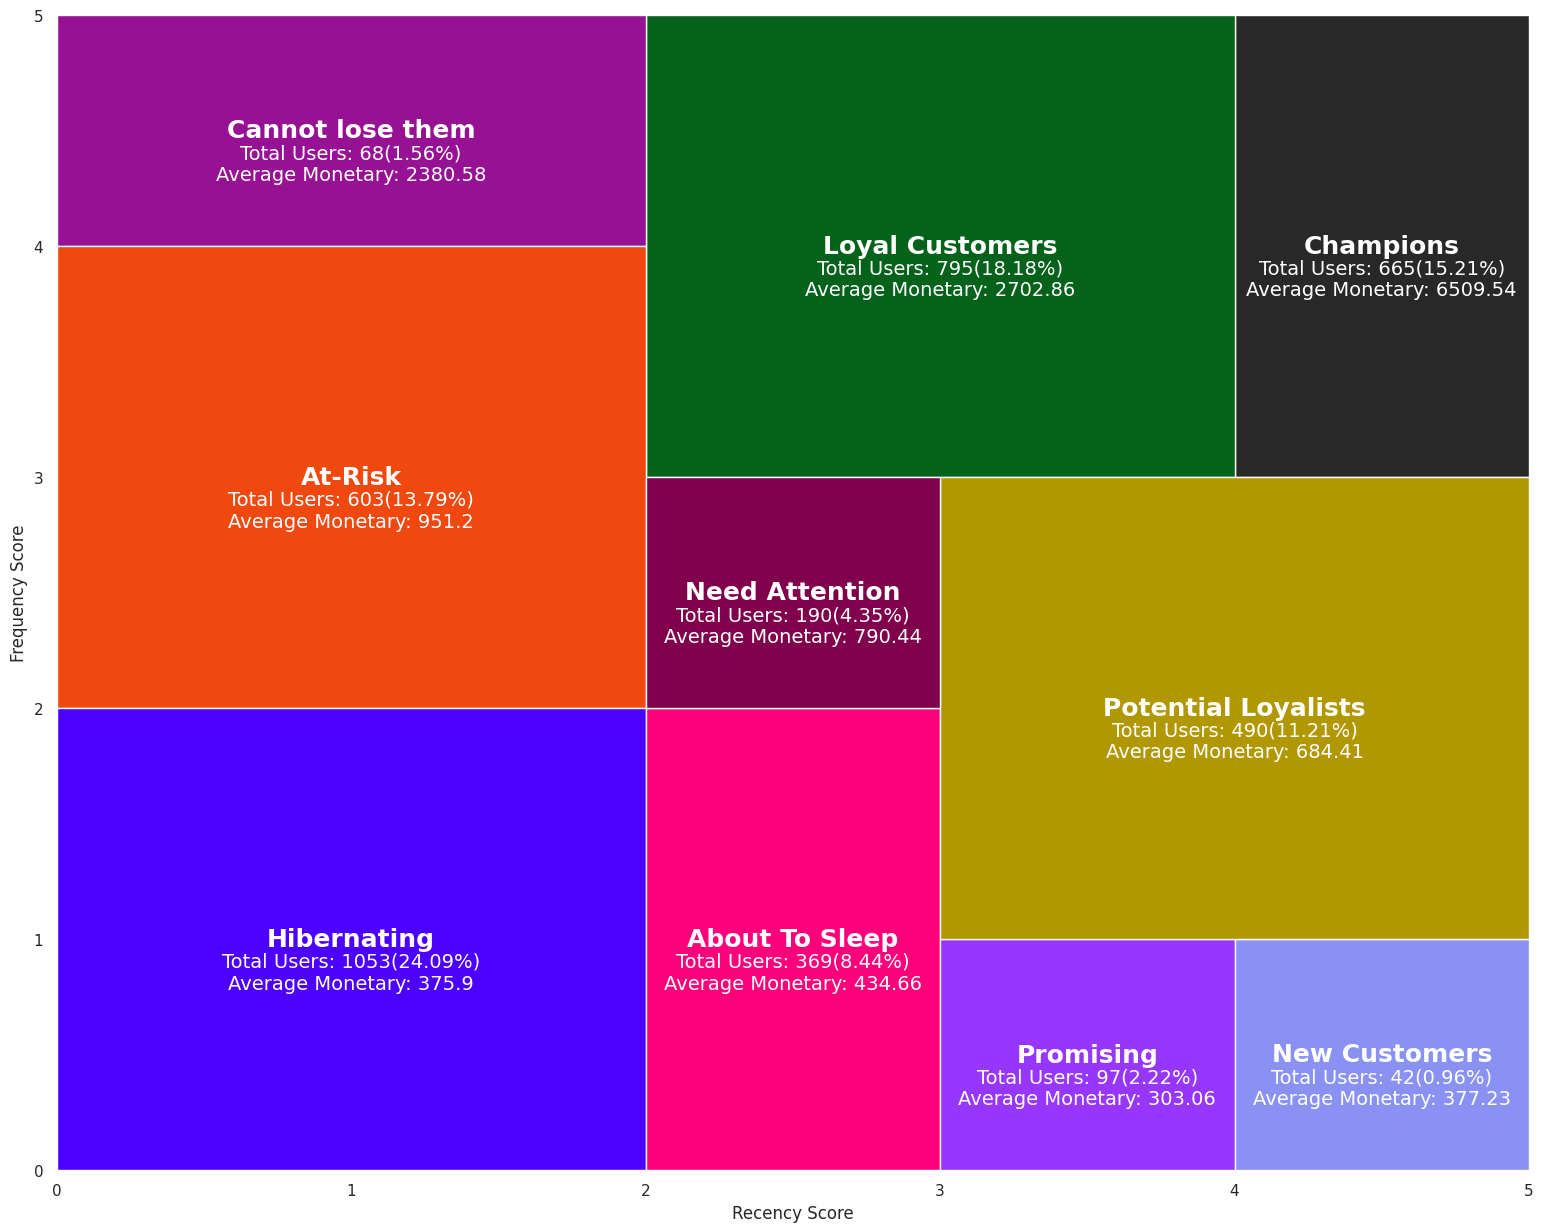

In [31]:
plot_rfm(rfm_table)